In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Engagement analysis

In [2]:
# read data
engagement = pd.read_csv("../relax_challenge/takehome_user_engagement.csv")
print(engagement.head())
print(engagement.info())

            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [3]:
# convert data type of 'time_stamp'
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

# how many unique user_id?
print(engagement['user_id'].nunique())

8823


Defining   an   "adopted   user"   as   a   user   who   has   logged   into   the   product   on   three   separate
days   in   at   least   one   seven­day   period ,   identify   which   factors   predict   future   user
adoption 

In [4]:
engagement['day'] = engagement['time_stamp'].dt.date

In [5]:
adopted = engagement.groupby("user_id").apply(
    lambda df: any(
        df.drop_duplicates(subset="day")
        .sort_values("day")["day"]
        .diff(periods=2)
        <= timedelta(days=7)
    )
)

In [6]:
adopted =adopted[adopted ==True]
adopted = pd.DataFrame(adopted)
adopted['user_id'] = adopted.index

In [7]:
adopted_id = adopted['user_id'].unique()

engagement['adopted_users'] = engagement['user_id'].apply(lambda x: 1 if x in adopted_id else 0)
engagement.head()

,time_stamp,user_id,visited,day,adopted_users
0,2014-04-22 03:53:30,1,1,2014-04-22,0
1,2013-11-15 03:45:04,2,1,2013-11-15,1
2,2013-11-29 03:45:04,2,1,2013-11-29,1
3,2013-12-09 03:45:04,2,1,2013-12-09,1
4,2013-12-25 03:45:04,2,1,2013-12-25,1


# Users Analysis

In [8]:
users = pd.read_csv("../relax_challenge/takehome_users.csv",encoding='latin-1')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [9]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])

users['recorded'] = (users['last_session_creation_time']-users['creation_time']).dt.days

# add adopted_users to users dataframe
users['adopted_users'] = users['object_id'].apply(lambda x: 1 if x in adopted_id else 0)


### Check the percentage of adopted users in opted_in_to_mailing_list, creation_source and enabled_for_marketing_drip

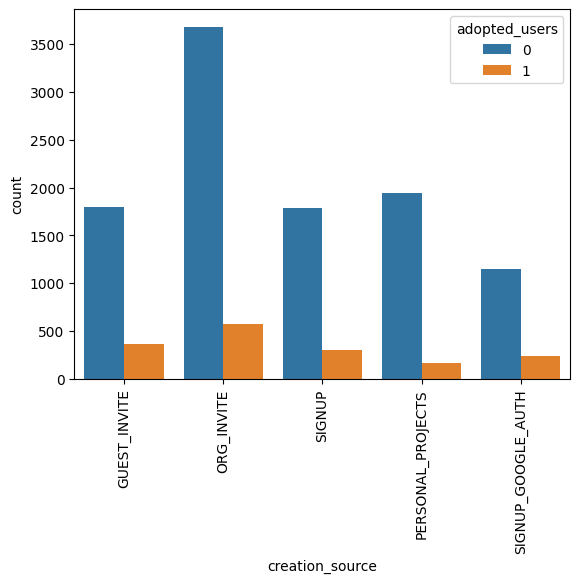

In [10]:
users.groupby(['adopted_users','creation_source'])['object_id'].count()/len(users)
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=users, hue='adopted_users')
_ = plt.xticks(rotation=90)

In [11]:
users.groupby(['adopted_users','opted_in_to_mailing_list'])['object_id'].count()/len(users)

adopted_users  opted_in_to_mailing_list
0              0                           0.64825
               1                           0.21375
1              0                           0.10225
               1                           0.03575
Name: object_id, dtype: float64

In [12]:
users.groupby(['adopted_users','enabled_for_marketing_drip'])['object_id'].count()/len(users)

adopted_users  enabled_for_marketing_drip
0              0                             0.734083
               1                             0.127917
1              0                             0.116583
               1                             0.021417
Name: object_id, dtype: float64

As it shows there is no obvious difference of adopted_users and unadopted users in enabled_for_marketing_drip and opted_in_to_mailing_list

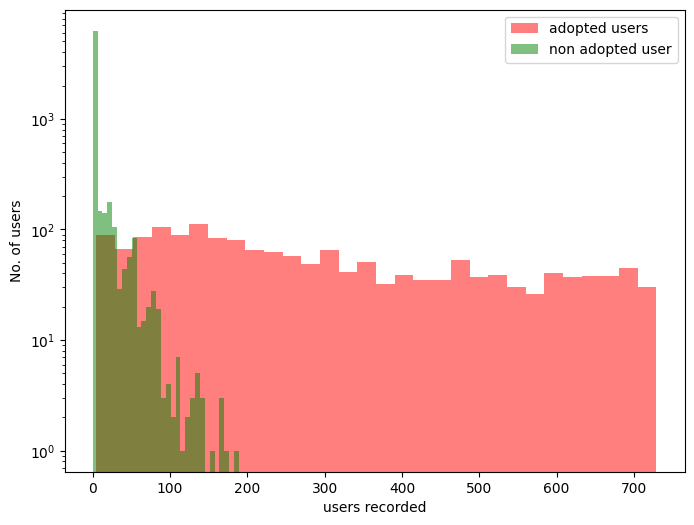

In [13]:
plt.figure(figsize =(8,6))
_ = plt.hist(users.loc[users['adopted_users']==1, 'recorded'], 
                 bins=30, alpha=0.5, color='r', label='adopted users')
_ = plt.hist(users.loc[users['adopted_users']==0, 'recorded'], 
                 bins=30, alpha=0.5, color='g', label='non adopted user')
_ = plt.yscale('log')
_ = plt.legend()
_ = plt.xlabel("users recorded")
_ = plt.ylabel('No. of users')


In [14]:
dummy = pd.get_dummies(users['creation_source'], drop_first = True,dtype='int')
user2 = pd.concat([users, dummy],axis = 1).drop('creation_source', axis = 1)
user2.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,recorded,adopted_users,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,136.0,1,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,5.0,0,0,0,0,0


# Build a predictive model

In [15]:
user3 = user2.drop(['name','email','creation_time','last_session_creation_time'], axis =1).dropna()
X= user3.drop(['adopted_users'],axis =1)
y = user3['adopted_users']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25, random_state = 42)

In [17]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [18]:
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [19]:
model = RandomizedSearchCV(clf, error_score='raise',param_distributions=param_grid)
model.fit(X_train, y_train)
print(model.best_estimator_)
print(model.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=None,
                       max_leaf_nodes=9, n_estimators=50, random_state=42)
0.9489076147510966


In [20]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9438860971524288
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       958
           1       0.82      0.92      0.87       236

    accuracy                           0.94      1194
   macro avg       0.90      0.94      0.92      1194
weighted avg       0.95      0.94      0.95      1194



In [21]:
imp = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

recorded                      0.979059
org_id                        0.010177
object_id                     0.005689
invited_by_user_id            0.004385
opted_in_to_mailing_list      0.000297
enabled_for_marketing_drip    0.000274
ORG_INVITE                    0.000119
PERSONAL_PROJECTS             0.000000
SIGNUP                        0.000000
SIGNUP_GOOGLE_AUTH            0.000000
dtype: float64
